In [ ]:
%pip install netCDF4
%pip install cartopy
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Function to read the netCDF Data files

In [ ]:
import numpy as np
import pandas as pd
import netCDF4
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime
from scipy.stats import pearsonr


# Function to load NetCDF data
def read_nc(filename):
    """
    Function read_nc
    Read a monthly climate data netCDF file and extract map series and dates
    :param filename: filename as a string
    :returns: (map series: numpy array(month,lat,lon), dates: list[(year,month)])
    """
    nc1 = netCDF4.Dataset(filename)
    # the temperature data could be called different things -
    # this trick picks the data element with the highest number of dimensions
    key = sorted([(nc1.variables[k].ndim, k) for k in nc1.variables])[-1][1]
    tmaps = np.ma.filled(nc1.variables[key][:, :, :], np.nan)
    time1 = nc1.variables["time"][:]
    unit1 = nc1.variables["time"].units
    latitudes = nc1.variables["latitude"][:]
    longitudes = nc1.variables["longitude"][:]
    dates = netCDF4.num2date(time1, units=unit1)
    dates = [pd.Timestamp(date.year, date.month, date.day) for date in dates]  # Converting to pandas timestamps
    return tmaps, dates, latitudes, longitudes

In [ ]:
# read in data from .nc file
tmaps_crutem, dates_crutem, latitudes_crutem, longitudes_crutem = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/CRUTEM.5.0.2.0.anomalies (1).nc")
# read in data from .nc file
tmaps_hadsst, dates_hadsst, latitudes_hadsst, longitudes_hadsst = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/HadSST.4.0.1.0_median (1).nc")

# Function to reduce the grid size to 10 degree grid

In [ ]:
# Reduce to 10 degree grid
def reduce_grid_size(tmaps):
    tmaps_reduced = tmaps.reshape([tmaps.shape[0], tmaps.shape[1] // 2, 2, tmaps.shape[2] // 2, 2])
    tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))
    return tmaps_reduced

tmaps_crutem_reduced = reduce_grid_size(tmaps_crutem)
tmaps_hadsst_reduced = reduce_grid_size(tmaps_hadsst)

# Define reduced latitudes and longitudes
reduced_latitudes = latitudes_crutem[::2]
reduced_longitudes = longitudes_crutem[::2]

<ipython-input-5-f36ea910539d>:4: RuntimeWarning: Mean of empty slice
  tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))


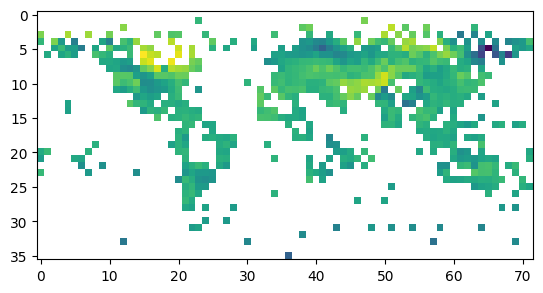

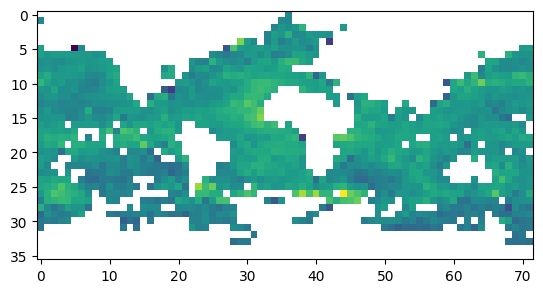

In [ ]:
# check coverage
plt.imshow(tmaps_crutem[-1,::-1,:])
plt.show()
plt.imshow(tmaps_hadsst[-1,::-1,:])
plt.show()

In [ ]:
 #get time series and derivatives from monthly means with incomplete data
def series_from_monthly_means(ymean, end_na=1):
  """
  Function series_from_monthly_means
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  n = len(ymean)
  tmat = (1.0 * np.eye(n, n, -1) + 4.0 * np.eye(n, n, 0) + 1.0 * np.eye(n, n, 1)) / 6.0
  cp = np.linalg.solve(tmat, ymean)
  y = np.convolve(cp, [1.0 / 8.0, 6.0 / 8.0, 1.0 / 8.0], mode="same")
  dy = np.convolve(cp, [0.5, 0.0, -0.5], mode="same")
  if end_na:
      y[: end_na] = np.nan
      y[-end_na:] = np.nan
      dy[: end_na] = np.nan
      dy[-end_na:] = np.nan
  return y, dy

In [ ]:
# Function to calculate series with incomplete data
def series_from_monthly_means_incomplete(ymean, end_na=1, min_obs=12 ):
  """
  Function series_from_monthly_means_incomplete
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  # get indices of non-missings
  i0 = np.nonzero(~np.isnan(ymean))[0]
  # find non-missing ranges
  i1 = np.roll(i0, 1)+1
  i2 = np.roll(i0,-1)-1
  i1 = i0[np.nonzero(i0!=i1)[0]]  # range start
  i2 = i0[np.nonzero(i0!=i2)[0]]  # range end
  assert np.sum(i2-i1+1) == np.count_nonzero(~np.isnan(ymean))
  # output arrays
  yfull  = np.full_like(ymean,np.nan)
  dyfull = np.full_like(ymean,np.nan)
  # gather data from ranges
  for i in range(len(i1)):
    # check there are sufficient data in range
    if (i2[i]-i1[i]>min_obs):
      #print(i0,i1[i],i2[i])
      yrange = ymean[i1[i]:i2[i]+1]
      y,dy = series_from_monthly_means(yrange,end_na)
      yfull[i1[i]:i2[i]+1]  = y
      dyfull[i1[i]:i2[i]+1] = dy
  return yfull,dyfull

# Defining function to find the values of To, Ts and thier derivatives then storing the values in new dataframe

In [ ]:
# Defining function to create a dataframe for a specific time interval
def create_df_for_time_interval(tmaps_crutem, tmaps_hadsst, dates_crutem, dates_hadsst, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    data = []
    for lat in range(tmaps_crutem.shape[1]):
        for lon in range(tmaps_crutem.shape[2]):
            crutem_series = tmaps_crutem[:, lat, lon]
            hadsst_series = tmaps_hadsst[:, lat, lon]

            y1, dy1 = series_from_monthly_means_incomplete(crutem_series, 1, 12) # land
            y2, dy2 = series_from_monthly_means_incomplete(hadsst_series, 1, 12)  # ocean

            for i in range(len(dates_crutem)):
                if start_date <= dates_crutem[i] <= end_date and not np.isnan(dy1[i]) and not np.isnan(dy2[i]):
                    data.append({
                        'date': dates_crutem[i],
                        'dTo': dy2[i],
                        'To': y2[i],
                        'dTs': dy1[i],
                        'Ts': y1[i],
                        'lat': lat,
                        'lon': lon
                    })
    return pd.DataFrame(data)

# Creating the dataframes for the time intervals 1961-1990 and 1991-2020
df_1961_1990 = create_df_for_time_interval(tmaps_crutem_reduced, tmaps_hadsst_reduced, dates_crutem, dates_hadsst, '1961-01-01', '1990-12-31')
df_1991_2020 = create_df_for_time_interval(tmaps_crutem_reduced, tmaps_hadsst_reduced, dates_crutem, dates_hadsst, '1991-01-01', '2020-12-31')



In [ ]:
# Display the dataframe for the time interval 1961-1990
print("DataFrame for 1961-1990:")
print(df_1961_1990)


DataFrame for 1961-1990:
            date       dTo        To       dTs        Ts  lat  lon
0     1969-06-16 -0.712712 -0.884572  0.338907  0.557438    3   10
1     1969-07-16  1.538569 -0.858326  0.280940 -0.359774    3   10
2     1969-08-16  1.494918  1.618833  0.335333  1.147408    3   10
3     1969-09-16 -2.823751  1.062756 -1.534273 -0.170107    3   10
4     1969-10-16 -0.492240 -2.366125 -0.146242 -1.106729    3   10
...          ...       ...       ...       ...       ...  ...  ...
72626 1990-07-16 -0.650708  2.439485 -0.106319  4.513792   16   23
72627 1990-08-16 -0.791123  1.837604 -3.164862  1.250087   16   23
72628 1990-09-16 -0.923660  0.859209  0.833268 -0.051765   16   23
72629 1990-10-16 -0.287419  0.182478 -4.018712  0.704096   16   23
72630 1990-11-16  0.019739  0.202099 -0.073422 -5.889870   16   23

[72631 rows x 7 columns]


In [ ]:
# Display the dataframe for the time interval 1991-2020
print("DataFrame for 1991-2020:")
print(df_1991_2020)

DataFrame for 1991-2020:
            date       dTo        To       dTs         Ts  lat  lon
0     2006-12-16 -0.039027  1.454383  1.239362   1.109615    2   11
1     2007-01-16 -0.137819  1.410482 -0.357844   1.126986    2   11
2     2007-02-15 -0.964286  0.996826 -0.746985   0.695943    2   11
3     2007-03-16 -0.475132 -0.189184 -0.579715  -0.227882    2   11
4     2007-04-16  0.258361  0.107647  1.666344   0.056211    2   11
...          ...       ...       ...       ...        ...  ...  ...
63737 2016-12-16 -0.307573  0.687005  3.296683   1.043406   16   25
63738 2017-01-16  0.744810  0.369980  2.729501  13.177860   16   25
63739 2017-02-15  0.204300  1.778401 -1.925186   5.480531   16   25
63740 2017-03-16 -0.940469  0.627515  0.217744  11.026892   16   25
63741 2017-04-16  0.041752  0.429211 -7.191290   3.528028   16   25

[63742 rows x 7 columns]


# Calculating the grid values A, B, C by fitting the temperature anomalies and thier derivatives in OLS regression

In [ ]:
# Defining the function to align and to calculate the coefficients from the dataframe
def align_and_calculate_coefficients_from_df(df, lat_len, lon_len):
    A_grid = np.full((lat_len, lon_len), np.nan)
    B_grid = np.full((lat_len, lon_len), np.nan)
    C_grid = np.full((lat_len, lon_len), np.nan)

    for lat in range(lat_len):
        for lon in range(lon_len):
            grid_data = df[(df['lat'] == lat) & (df['lon'] == lon)]
            if len(grid_data) >= 200:
                # construct equations
                y = grid_data['dTo']
                X = grid_data[['dTs', 'To', 'Ts']]
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                A_grid[lat, lon] = model.params['dTs']
                B_grid[lat, lon] = -model.params['To']/2.63e6
                C_grid[lat, lon] = model.params['Ts']/2.63e6

    return A_grid, B_grid, C_grid

# Calculating the coefficients for 1961-1990 and 1991-2020
A_grid_1961_1990, B_grid_1961_1990, C_grid_1961_1990 = align_and_calculate_coefficients_from_df(df_1961_1990, tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2])
A_grid_1991_2020, B_grid_1991_2020, C_grid_1991_2020 = align_and_calculate_coefficients_from_df(df_1991_2020, tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2])


# Displaying the Coefficeint Values of A, B, C from the period 1961-1990

In [ ]:
A_grid_1961_1990, B_grid_1961_1990, C_grid_1961_1990

(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
               

#Displaying the Coefficeint Values of A, B, C from the period 1991-2020

In [ ]:
A_grid_1991_2020, B_grid_1991_2020, C_grid_1991_2020

(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
               

# Outlier detection and removing those for final analysis using Z score and iqr methods

In [ ]:
# Creating function to identify the outliers
def identify_outliers(data, method='zscore', threshold=3):
    if method == 'zscore':
        mean = np.nanmean(data)
        std = np.nanstd(data)
        z_scores = (data - mean) / std
        outliers = np.abs(z_scores) > threshold
    elif method == 'iqr':
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
    else:
        raise ValueError("Unsupported method. Choose 'zscore' or 'iqr'.")
    return outliers

In [ ]:
#create function to remove the outliers
def remove_outliers(data, outliers):
    data_cleaned = np.copy(data)
    data_cleaned[outliers] = np.nan
    return data_cleaned

# Function for Scatterplot analysis

In [ ]:
import matplotlib.pyplot as plt
# Function to scatter plot coefficients without outliers
def scatter_plot_coefficients(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, 'o')
    plt.axline((0, 0), slope=1, color="k")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('square')
    plt.grid(True)
    plt.show()

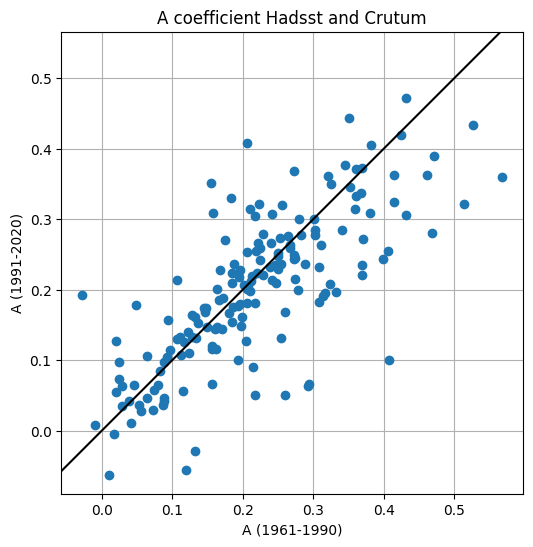

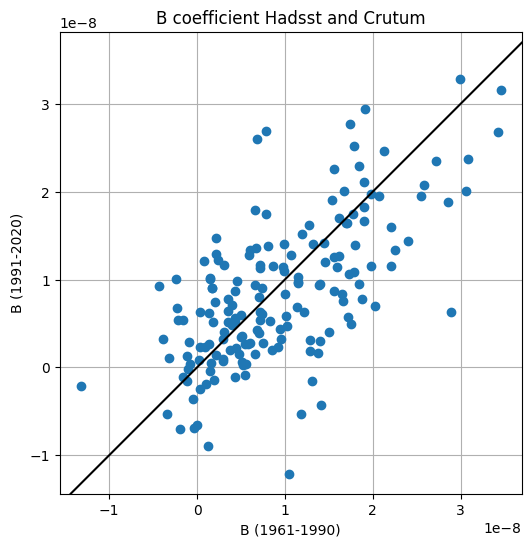

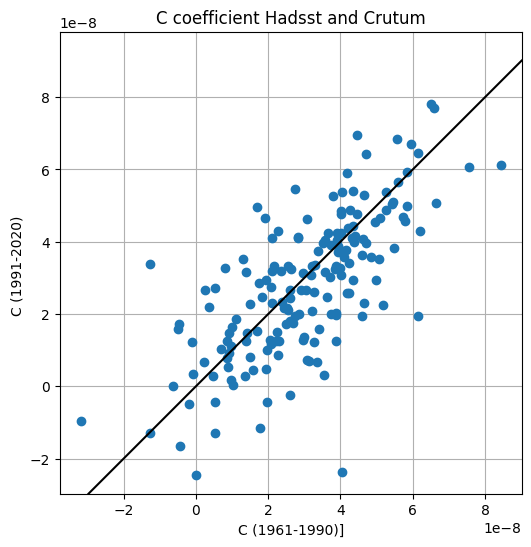

In [ ]:
# Identify outliers in the A, B, and C coefficient grids for 1961-1990 and 1991-2020
outliers_A_1961_1990_1 = identify_outliers(A_grid_1961_1990, method='zscore', threshold=3)
outliers_B_1961_1990_1 = identify_outliers(B_grid_1961_1990, method='zscore', threshold=3)
outliers_C_1961_1990_1 = identify_outliers(C_grid_1961_1990, method='zscore', threshold=3)

outliers_A_1991_2020_1 = identify_outliers(A_grid_1991_2020, method='zscore', threshold=3)
outliers_B_1991_2020_1 = identify_outliers(B_grid_1991_2020, method='zscore', threshold=3)
outliers_C_1991_2020_1 = identify_outliers(C_grid_1991_2020, method='zscore', threshold=3)



# Removing outliers from the grids for 1961-1990 and 1991-2020
A_grid_1961_1990_cleaned_1 = remove_outliers(A_grid_1961_1990, outliers_A_1961_1990_1)
B_grid_1961_1990_cleaned_1 = remove_outliers(B_grid_1961_1990, outliers_B_1961_1990_1)
C_grid_1961_1990_cleaned_1 = remove_outliers(C_grid_1961_1990, outliers_C_1961_1990_1)

A_grid_1991_2020_cleaned_1 = remove_outliers(A_grid_1991_2020, outliers_A_1991_2020_1)
B_grid_1991_2020_cleaned_1 = remove_outliers(B_grid_1991_2020, outliers_B_1991_2020_1)
C_grid_1991_2020_cleaned_1 = remove_outliers(C_grid_1991_2020, outliers_C_1991_2020_1)



# Flatten the cleaned coefficient grids for comparison
A_1961_1990_flat_cleaned_1 = A_grid_1961_1990_cleaned_1.flatten()
A_1991_2020_flat_cleaned_1 = A_grid_1991_2020_cleaned_1.flatten()

B_1961_1990_flat_cleaned_1 = B_grid_1961_1990_cleaned_1.flatten()
B_1991_2020_flat_cleaned_1 = B_grid_1991_2020_cleaned_1.flatten()

C_1961_1990_flat_cleaned_1 = C_grid_1961_1990_cleaned_1.flatten()
C_1991_2020_flat_cleaned_1 = C_grid_1991_2020_cleaned_1.flatten()

# Scatter plot comparison for A coefficients without outliers
scatter_plot_coefficients(A_1961_1990_flat_cleaned_1, A_1991_2020_flat_cleaned_1,
                          "A coefficient Hadsst and Crutum",
                          "A (1961-1990)", "A (1991-2020)")

# Scatter plot comparison for B coefficients without outliers
scatter_plot_coefficients(B_1961_1990_flat_cleaned_1, B_1991_2020_flat_cleaned_1,
                          "B coefficient Hadsst and Crutum",
                          "B (1961-1990)", "B (1991-2020)")

# Scatter plot comparison for C coefficients without outliers
scatter_plot_coefficients(C_1961_1990_flat_cleaned_1, C_1991_2020_flat_cleaned_1,
                          "C coefficient Hadsst and Crutum",
                          "C (1961-1990)]", "C (1991-2020) ")


# Function for Latitidinal boxplot with median

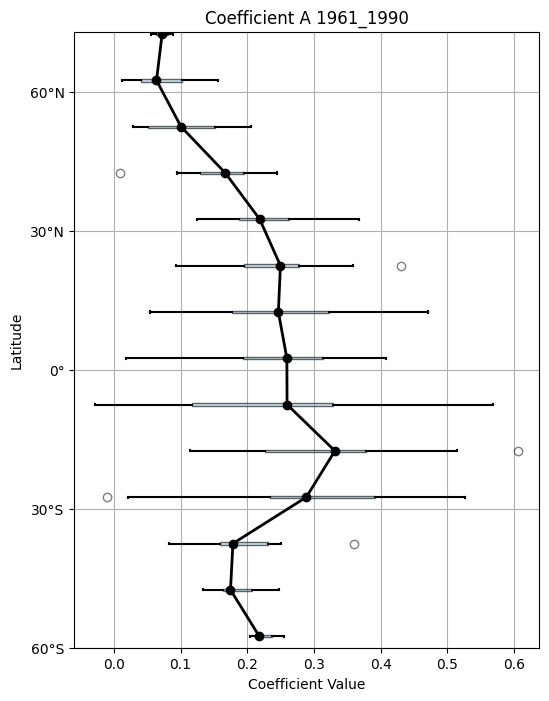

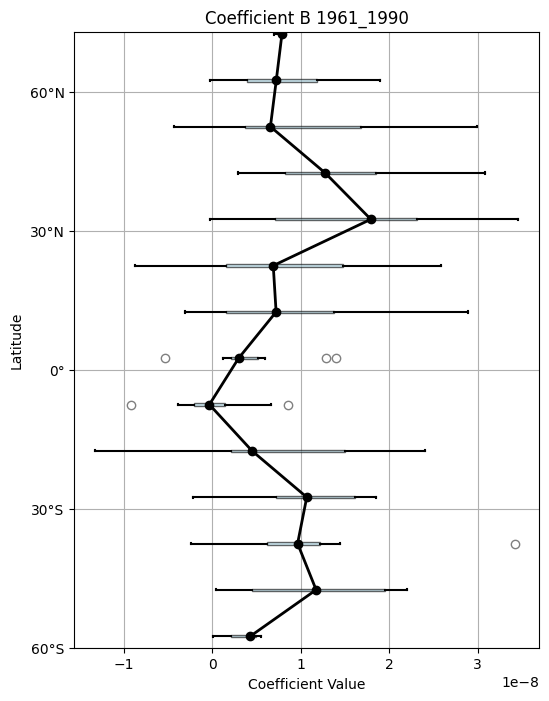

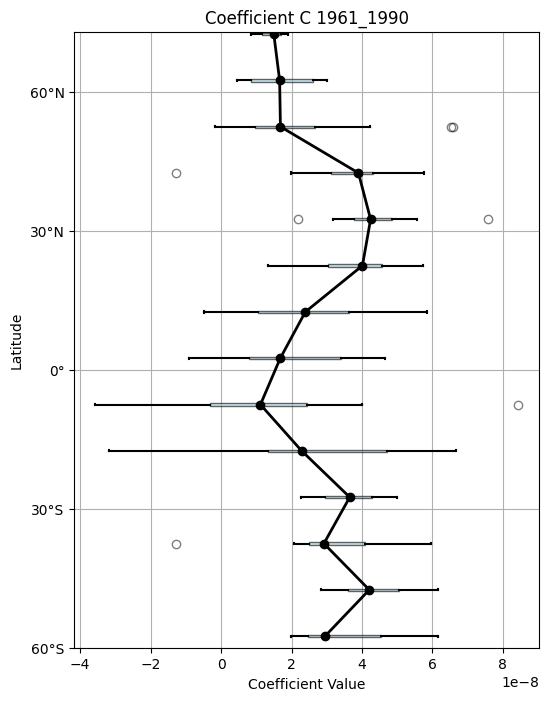

In [ ]:
def plot_custom_boxplot_with_medians(coefficient, latitudes, title):
    # Converting the data to pandas DataFrame for easier processing
    df = pd.DataFrame({'Latitude': latitudes, 'Coefficient': coefficient})

    # Dropping rows with NaN coefficient values
    df = df.dropna(subset=['Coefficient'])

    plt.figure(figsize=(6, 8))

    # Preparing the data for boxplot
    latitude_bins = np.unique(df['Latitude'])
    boxplot_data = [df[df['Latitude'] == lat]['Coefficient'].dropna() for lat in latitude_bins]

    # Create the boxplot
    box = plt.boxplot(boxplot_data, vert=False, positions=latitude_bins, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='black'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', color='black', alpha=0.5))

    # Shading for the interquartile range (IQR)
    for patch in box['boxes']:
        patch.set(facecolor='lightblue', alpha=0.6)

    # Whiskers and caps
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1.5)

    for cap in box['caps']:
        cap.set(color='black', linewidth=1.5)

    # Median line properties
    for median in box['medians']:
        median.set(color='black', linewidth=2)

    # Plotting outliers
    for flier in box['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

    # Calculating the median for each latitude bin
    median_coefficients = [data.median() for data in boxplot_data]

    # Plot the median line with connecting points
    plt.plot(median_coefficients, latitude_bins, 'o-', color='black', linewidth=2)

    # Set y-axis to specific ticks
    plt.yticks(ticks=np.arange(-60, 70, 30), labels=['60°S', '30°S', '0°', '30°N', '60°N'])

    # Set x-axis label, y-axis label, and title
    plt.xlabel('Coefficient Value')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_custom_boxplot_with_medians(A_grid_1961_1990_cleaned_1.flatten(), np.repeat(reduced_latitudes, A_grid_1961_1990_cleaned_1.shape[1]), "Coefficient A 1961_1990")
plot_custom_boxplot_with_medians(B_grid_1961_1990_cleaned_1.flatten(), np.repeat(reduced_latitudes, B_grid_1961_1990_cleaned_1.shape[1]), "Coefficient B 1961_1990")
plot_custom_boxplot_with_medians(C_grid_1961_1990_cleaned_1.flatten(), np.repeat(reduced_latitudes, C_grid_1961_1990_cleaned_1.shape[1]), "Coefficient C 1961_1990")


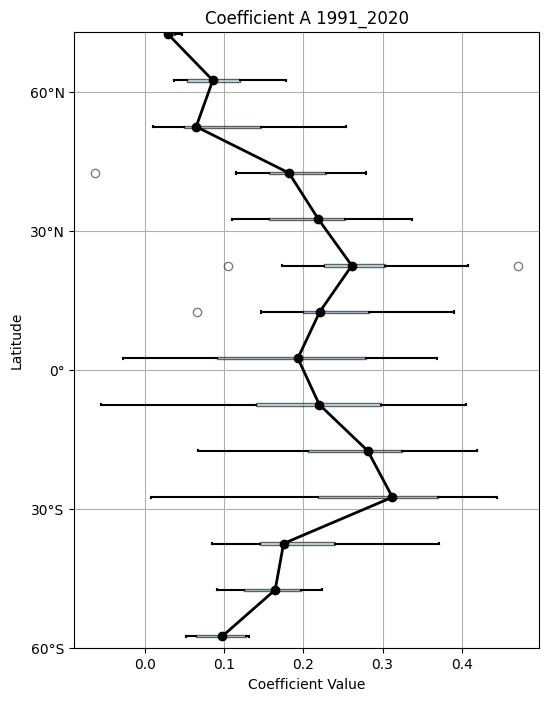

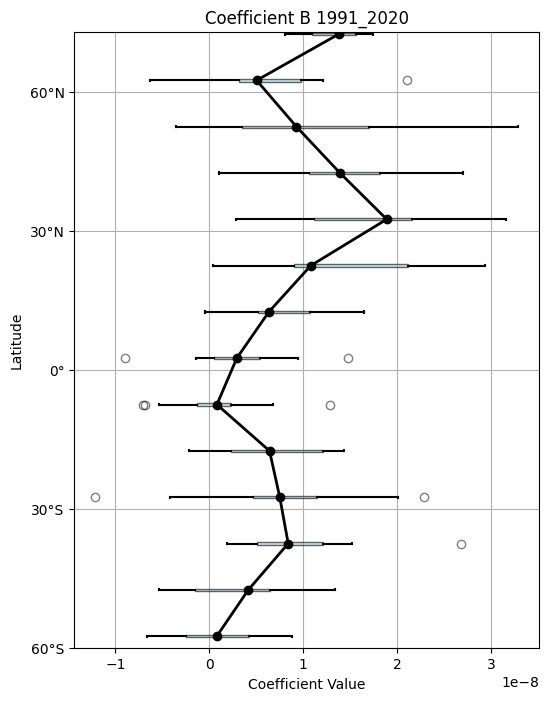

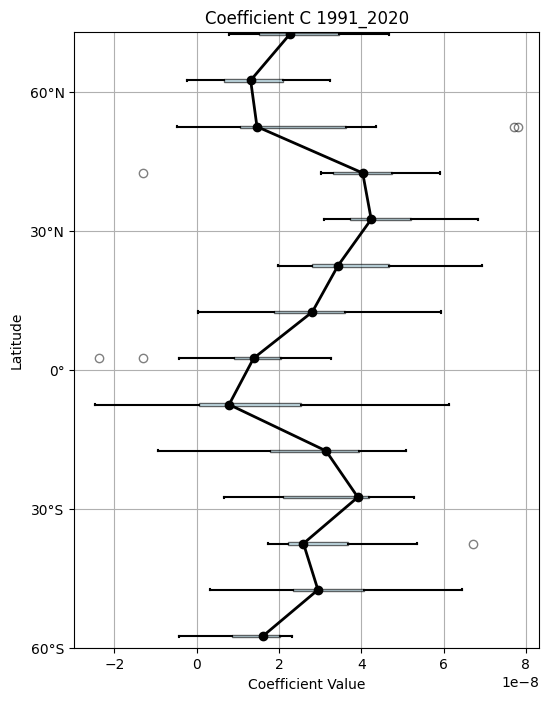

In [ ]:
plot_custom_boxplot_with_medians(A_grid_1991_2020_cleaned_1.flatten(), np.repeat(reduced_latitudes, A_grid_1991_2020_cleaned_1.shape[1]), "Coefficient A 1991_2020")
plot_custom_boxplot_with_medians(B_grid_1991_2020_cleaned_1.flatten(), np.repeat(reduced_latitudes, B_grid_1991_2020_cleaned_1.shape[1]), "Coefficient B 1991_2020")
plot_custom_boxplot_with_medians(C_grid_1991_2020_cleaned_1.flatten(), np.repeat(reduced_latitudes, C_grid_1991_2020_cleaned_1.shape[1]), "Coefficient C 1991_2020")


# Function for Spatial coefficeint analysis

In [ ]:
def plot_coefficient_spatially(latitudes, longitudes, coefficient, title, scale_factor=1, unit=''):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    lons, lats = np.meshgrid(longitudes, latitudes)
    c = ax.pcolormesh(lons, lats, coefficient * scale_factor, cmap='coolwarm', shading='auto', vmin=np.nanmin(coefficient * scale_factor), vmax=np.nanmax(coefficient * scale_factor))
    ax.coastlines()
    ax.set_title(title)
    cbar = fig.colorbar(c, ax=ax, orientation='vertical', pad=0.05, location='left')
    cbar.set_label(unit)
    plt.show()

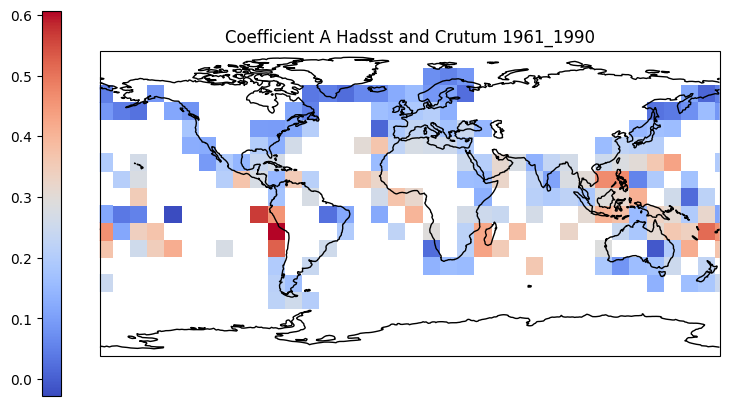

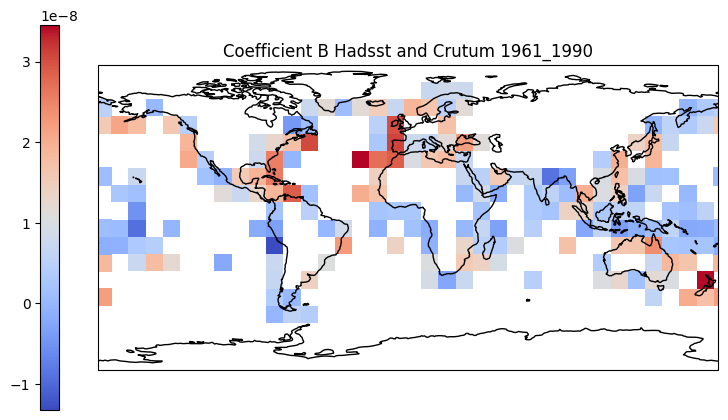

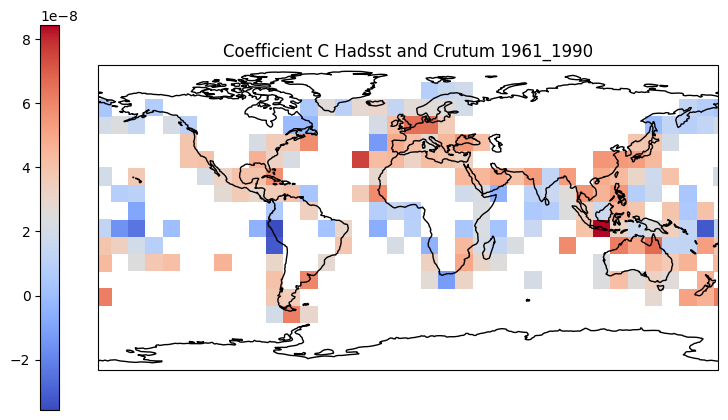

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_1961_1990_cleaned_1, "Coefficient A Hadsst and Crutum 1961_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_1961_1990_cleaned_1, "Coefficient B Hadsst and Crutum 1961_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_1961_1990_cleaned_1, "Coefficient C Hadsst and Crutum 1961_1990")

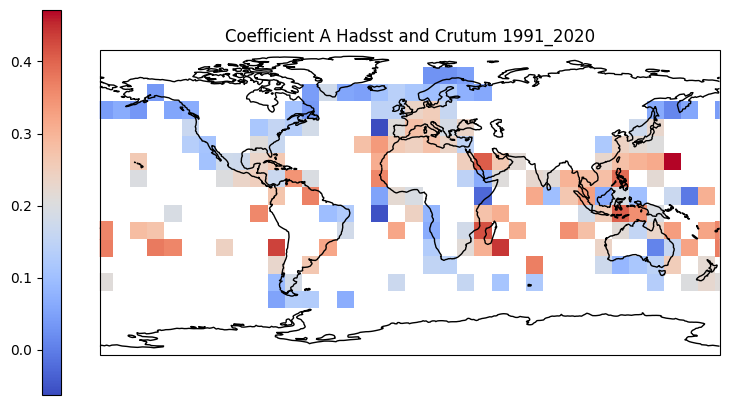

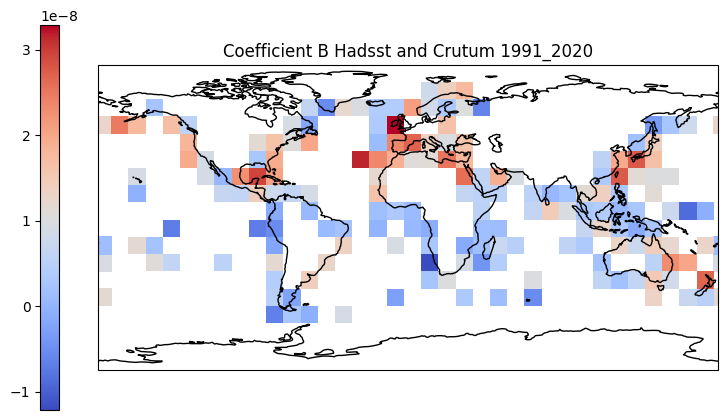

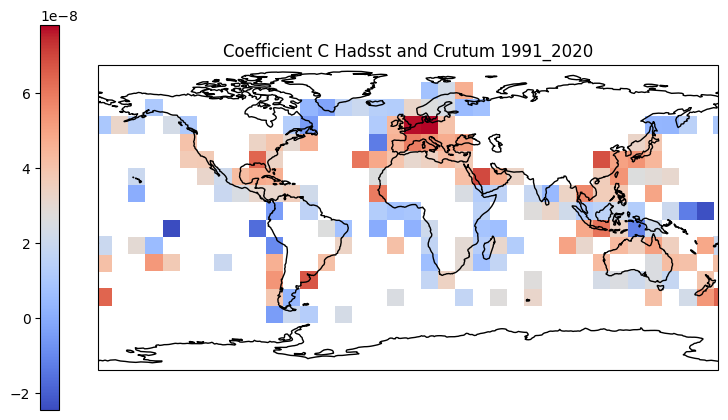

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_1991_2020_cleaned_1, "Coefficient A Hadsst and Crutum 1991_2020")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_1991_2020_cleaned_1, "Coefficient B Hadsst and Crutum 1991_2020")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_1991_2020_cleaned_1, "Coefficient C Hadsst and Crutum 1991_2020")

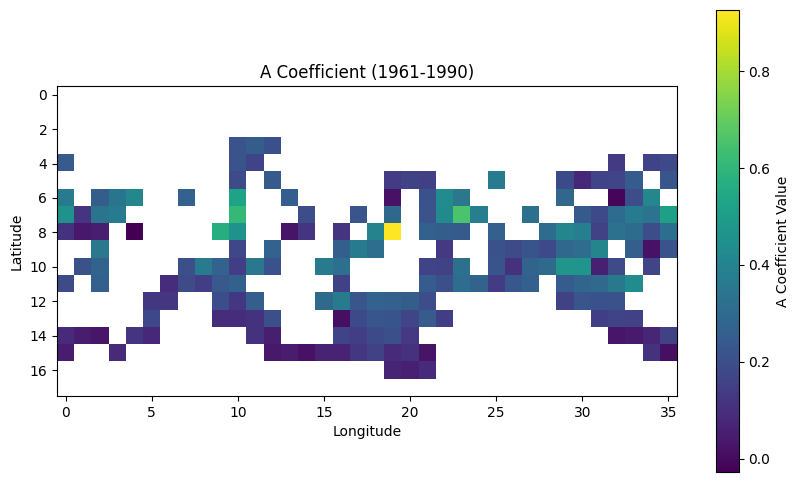

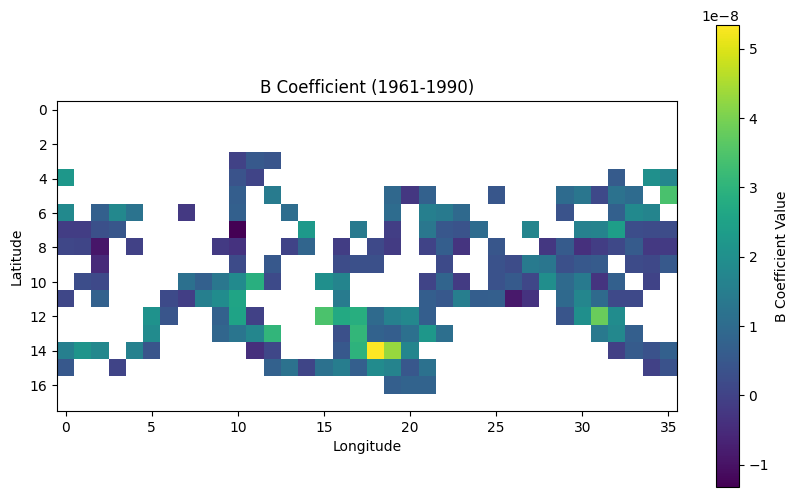

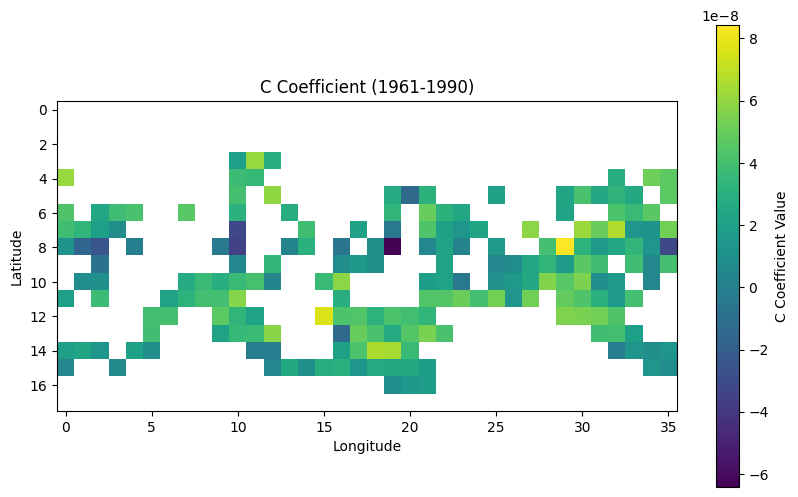

In [ ]:
# Plot for A coefficient (1961-1990)
plt.figure(figsize=(10, 6))
plt.title('A Coefficient (1961-1990)')
plt.imshow(A_grid_1961_1990, cmap='viridis')
plt.colorbar(label='A Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot for B coefficient (1961-1990)
plt.figure(figsize=(10, 6))
plt.title('B Coefficient (1961-1990)')
plt.imshow(B_grid_1961_1990, cmap='viridis')
plt.colorbar(label='B Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot for C coefficient (1961-1990)
plt.figure(figsize=(10, 6))
plt.title('C Coefficient (1961-1990)')
plt.imshow(C_grid_1961_1990, cmap='viridis')
plt.colorbar(label='C Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

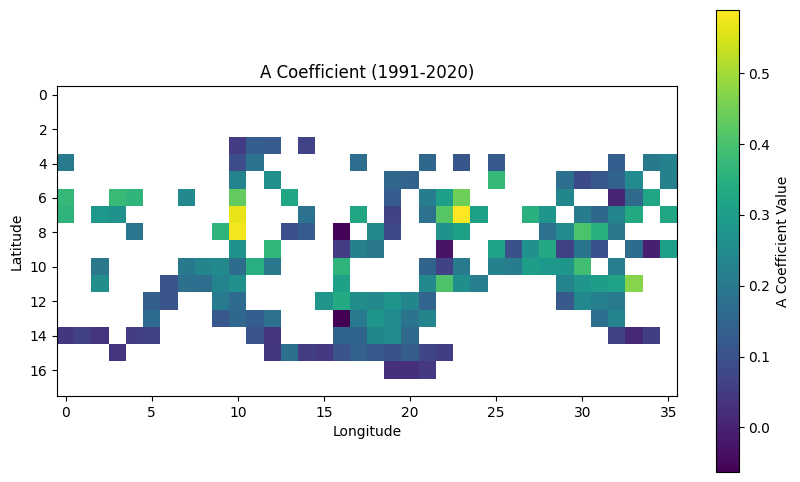

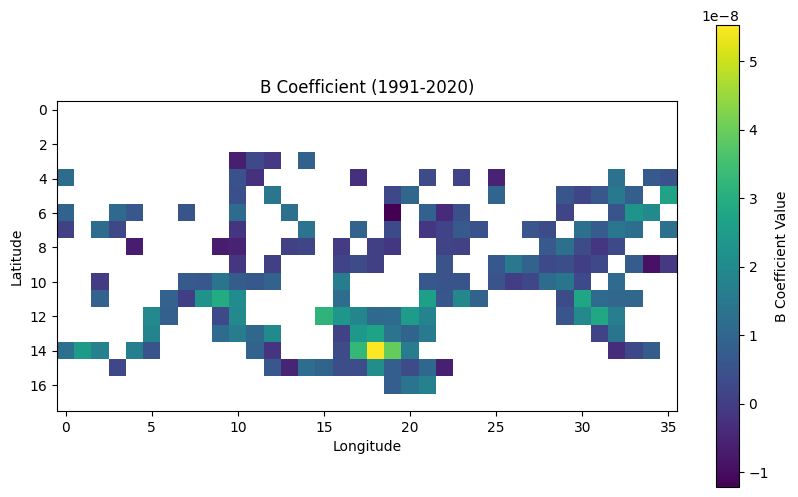

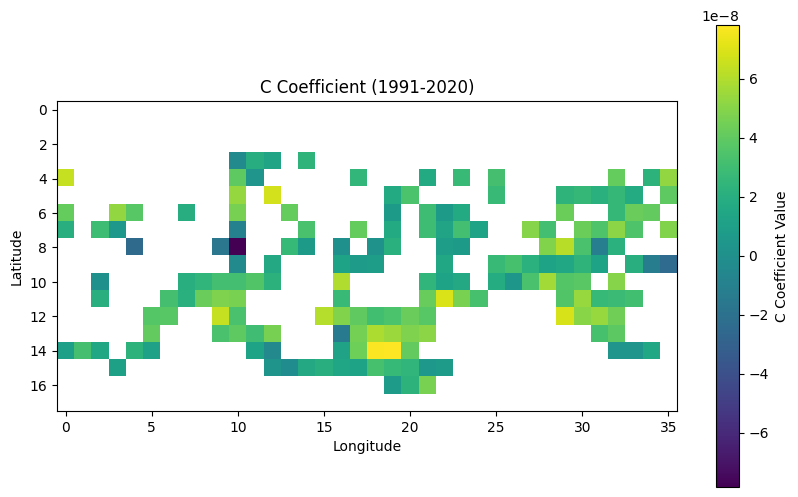

In [ ]:
# Plot for A coefficient (1991-2020)
plt.figure(figsize=(10, 6))
plt.title('A Coefficient (1991-2020)')
plt.imshow(A_grid_1991_2020, cmap='viridis')
plt.colorbar(label='A Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot for B coefficient (1991-2020)
plt.figure(figsize=(10, 6))
plt.title('B Coefficient (1991-2020)')
plt.imshow(B_grid_1991_2020, cmap='viridis')
plt.colorbar(label='B Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot for C coefficient (1991-2020)
plt.figure(figsize=(10, 6))
plt.title('C Coefficient (1991-2020)')
plt.imshow(C_grid_1991_2020, cmap='viridis')
plt.colorbar(label='C Coefficient Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Function for calculating the Pearson Correlation between two periods of Coefficient values(1961-1990 and 1991-2020)

In [ ]:
# Creating function to calculate the Pearson correlation coefficient between two grids
def calculate_pearson_correlation(coef_1961_1990, coef_1991_2020):
    # Flattening the arrays and removing NaN values for correlation calculation
    flat_1961_1990 = coef_1961_1990.flatten()
    flat_1991_2020 = coef_1991_2020.flatten()

    # Removing NaNs from both arrays
    mask = ~np.isnan(flat_1961_1990) & ~np.isnan(flat_1991_2020)
    clean_1961_1990 = flat_1961_1990[mask]
    clean_1991_2020 = flat_1991_2020[mask]

    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(clean_1961_1990, clean_1991_2020)
    return correlation

# Calculate Pearson correlation coefficients for A, B, and C grids
pearson_A = calculate_pearson_correlation(A_grid_1961_1990, A_grid_1991_2020)
pearson_B = calculate_pearson_correlation(B_grid_1961_1990, B_grid_1991_2020)
pearson_C = calculate_pearson_correlation(C_grid_1961_1990, C_grid_1991_2020)

print("Pearson coefficient of grid values for Hadsst and Crutum_1961_1990_and_1991_2020 ")
print("Pearson Correlation Coefficient for Coefficient A:", pearson_A)
print("Pearson Correlation Coefficient for Coefficient B:", pearson_B)
print("Pearson Correlation Coefficient for Coefficient C:", pearson_C)


Pearson coefficient of grid values for Hadsst and Crutum_1961_1990_and_1991_2020 
Pearson Correlation Coefficient for Coefficient A: 0.6890680194042532
Pearson Correlation Coefficient for Coefficient B: 0.7325482213988195
Pearson Correlation Coefficient for Coefficient C: 0.6936825853539794
